In [34]:
# Core libraries
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

 Data source: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

In [ ]:
# Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive

MyDrive


In [ ]:
# Install Kaggle API
# !pip install kaggle

### Don't run! This is only run once!

In [ ]:
# Upload your Kaggle API key
# Go to Kaggle → Account → settings → API → Create New Token
# This downloads a file called kaggle.json
# Upload it in Colab
from google.colab import files
files.upload()   # When the dialog opens, select kaggle.json from your computer

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"malihmahdavis","key":"4319effe652b7281620d193b5312f094"}'}

### Don't run! This is only run once!

In [ ]:
# Move kaggle.json to the right place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Don't run! This is only run once!

In [ ]:
# Make a folder for dataset
!mkdir -p /content/drive/MyDrive/flickr30k

### Don't run! This is only run once!

In [ ]:
# Download into Drive
!kaggle datasets download hsankesara/flickr-image-dataset -p /content/drive/MyDrive/flickr30k

Dataset URL: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset
License(s): CC0-1.0
100% 8.16G/8.16G [01:26<00:00, 65.2MB/s]
100% 8.16G/8.16G [01:26<00:00, 102MB/s] 


### Don't run! This is only run once!

In [ ]:
# Unzip into the folder
!unzip /content/drive/MyDrive/flickr-image-dataset.zip -d /content/drive/MyDrive

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: /content/drive/MyDrive/flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: /cont

### Runtime > Run cell and below

In [ ]:
# Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Show counts of files in each subdirectory
!find /content/drive/MyDrive/flickr30k_images/ -type d -exec sh -c 'echo -n "{}: "; find "{}" -maxdepth 1 -type f | wc -l' \;

/content/drive/MyDrive/flickr30k_images/: 9
/content/drive/MyDrive/flickr30k_images/flickr30k_images: find: ‘/content/drive/MyDrive/flickr30k_images/flickr30k_images’: Input/output error
0
/content/drive/MyDrive/flickr30k_images/features: 31783


In [ ]:
!find /content -type f -name "*results.csv*"

/content/drive/MyDrive/flickr30k_images/results.csv


In [ ]:
# How many images do we have?
import os

image_dir = "/content/drive/MyDrive/flickr30k_images/flickr30k_images"
num_images = sum(len(files) for _, _, files in os.walk(image_dir))
print("Total images:", num_images)

Total images: 31783


In [ ]:
len(os.listdir(image_dir))


31783

In [ ]:
# How many captions do we have?
csv_path = "/content/drive/MyDrive/flickr30k_images/results.csv"

with open(csv_path, "r", encoding="utf-8") as f:
    num_lines = sum(1 for _ in f)

print("Total lines in CSV:", num_lines)

Total lines in CSV: 158916


In [ ]:
# How many captions does each images have?
(num_lines-1)/num_images

5.0

### Display some of the images

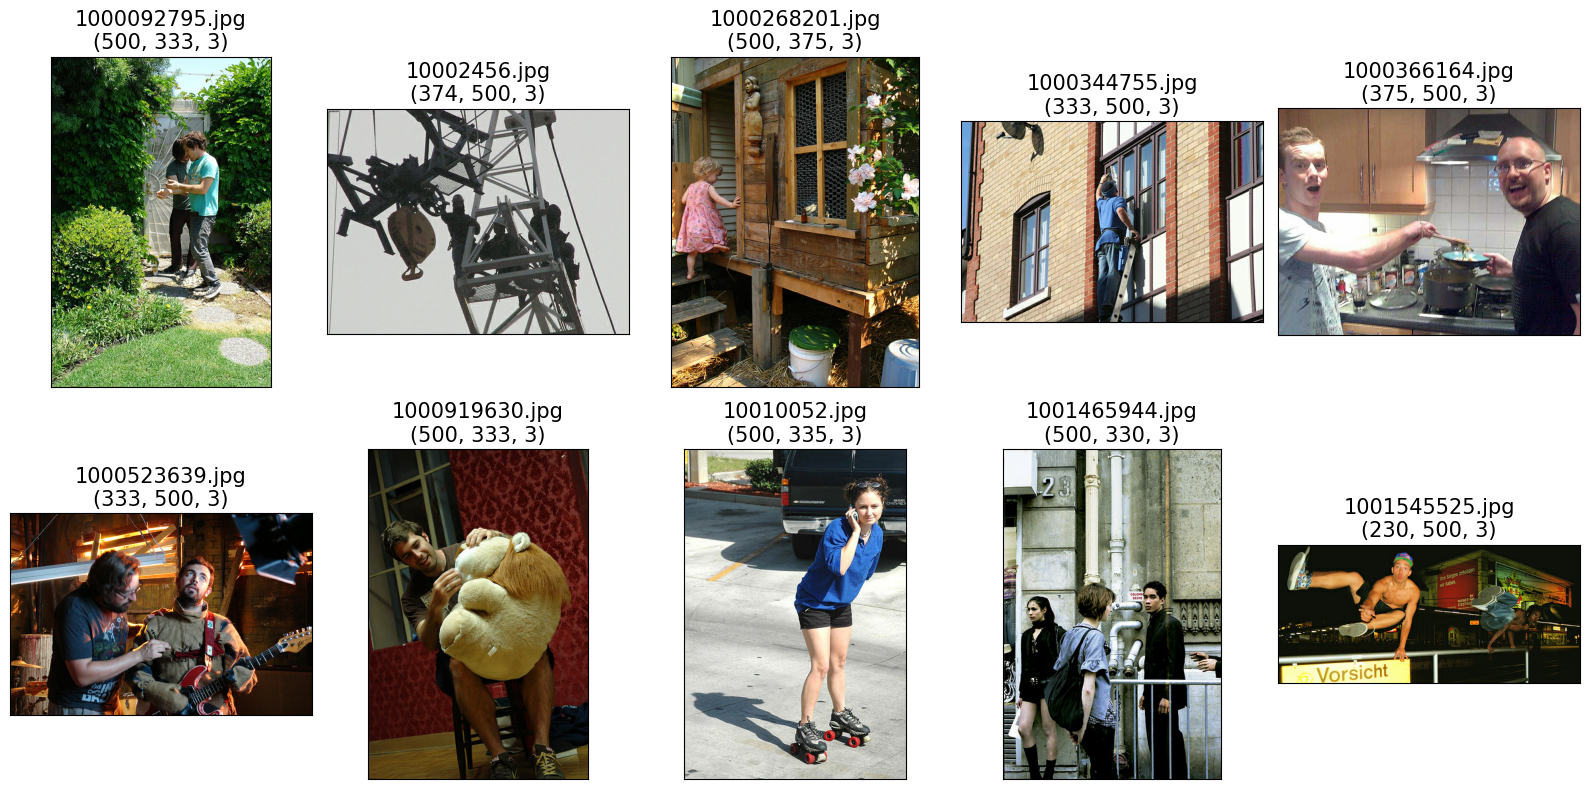

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pathlib

imgdir_path = pathlib.Path('/content/drive/MyDrive/flickr30k_images/flickr30k_images/')
img_list = sorted([str(path) for path in imgdir_path.glob('*.jpg')])

fig = plt.figure(figsize=(16, 8))
for i, f in enumerate(img_list[:10]):
  img_raw = tf.io.read_file(f)
  img = tf.image.decode_jpeg(img_raw).numpy()
  ax = fig.add_subplot(2, 5, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(img)
  ax.set_title(f"{os.path.basename(f)}\n{img.shape}", size=15)
plt.tight_layout()
plt.show();

### Display captions in a dataframe

In [ ]:
import pandas as pd

csv_path = "/content/drive/MyDrive/flickr30k_images/results.csv"
df = pd.read_csv(csv_path, delimiter='|')
df.head(12)

image_name  comment_number  \
0   1000092795.jpg               0   
1   1000092795.jpg               1   
2   1000092795.jpg               2   
3   1000092795.jpg               3   
4   1000092795.jpg               4   
5     10002456.jpg               0   
6     10002456.jpg               1   
7     10002456.jpg               2   
8     10002456.jpg               3   
9     10002456.jpg               4   
10  1000268201.jpg               0   
11  1000268201.jpg               1   

                                              comment  
0    Two young guys with shaggy hair look at their...  
1    Two young , White males are outside near many...  
2    Two men in green shirts are standing in a yard .  
3        A man in a blue shirt standing in a garden .  
4             Two friends enjoy time spent together .  
5    Several men in hard hats are operating a gian...  
6    Workers look down from up above on a piece of...  
7    Two men working on a machine wearing hard hats .  
8               Four men on top of a tall structure .  
9                          Three men on a large rig .  
10   A child in a pink dress is climbing up a set ...  
11   A little girl in a pink dress going into a wo...

In [ ]:
df.columns

Index(['image_name', ' comment_number', ' comment'], dtype='object')

In [ ]:
df.columns = df.columns.str.strip()

In [ ]:
df.describe()

image_name comment_number                          comment
count          158915         158915                           158914
unique          31783              6                           158438
top     998845445.jpg              0   Two dogs playing in the snow .
freq                5          31783                                7

In [ ]:
# Save df
with open('/content/drive/MyDrive/flickr30k_images/df.pkl', 'wb') as f:
    pickle.dump(df, f)

### Define function to preprocess text and delimit each caption

In [ ]:
import string
import nltk

table = str.maketrans('', '', string.punctuation)  # just delete punctuations

def text_preprocess(text):

  text = text.lower().split()
  text = [word for word in text if word.isalpha()]
  text = [w.translate(table) for w in text]
  text = [word for word in text if len(word)>1]
  text = "startseq "+' '.join(text)+ " endseq"

  return text

### Associates each image name with a list of preprocessed comments.

In [ ]:
mapping =  {}
for i,c in zip(df.image_name, df.comment):
  if i in mapping.keys():  # if i in mapping:
    if(type(c)==str):
      mapping[i].append(text_preprocess(c))
  else:
    mapping[i]=[text_preprocess(c)]

# Save mapping
with open('/content/drive/MyDrive/flickr30k_images/mapping.pkl', 'wb') as f:
    pickle.dump(mapping, f)

In [ ]:
mapping['1006452823.jpg']

['startseq two children girl and boy are practicing their writing endseq',
 'startseq two children sit on small seesaw in the sand endseq',
 'startseq two children sitting on teeter totter endseq',
 'startseq kids playing on seesaw endseq',
 'startseq two kids sit on seesaw endseq']

### Estimation of caption length

In [ ]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

# Save all_captions
with open('/content/drive/MyDrive/flickr30k_images/all_captions.pkl', 'wb') as f:
    pickle.dump(all_captions, f)


# Max length of the caption available
max_length_cap=max(len(caption.split())for caption in all_captions)
max_length_cap

74

### Extract vocabulary with tokenizer

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Save tokenizer
with open('/content/drive/MyDrive/flickr30k_images/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

vocab_dict = tokenizer.word_index
vocab_size = len(vocab_dict)+1         # total number of unique word, reserve index 0 for padding
vocab_size

17893

In [ ]:
# Confirm startseq, endseq exists in tokens
print(tokenizer.word_index.get('startseq'))
print(tokenizer.word_index.get('endseq'))

1
2


In [ ]:
# Save metadata
meta = {
    'vocab_dict': tokenizer.word_index,
    'vocab_size': len(tokenizer.word_index) + 1,
    'max_length_cap': max(len(c.split()) for c in all_captions)
}
with open('/content/drive/MyDrive/flickr30k_images/meta.pkl', 'wb') as f:
    pickle.dump(meta, f)

### Pretrained model for image feature extraction
About VGG: https://keras.io/api/applications/vgg/  Very Deep Convolutional Networks for Large-Scale Image Recognition.

VGG16 has been trained on a large subset of the ImageNet dataset, which contains over 14 million images, although the specific number of training images is about 1.2 million. The VGG16 model was designed to classify images into 1,000 object categories and achieved a high classification accuracy in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC)-2014.

### Setup VGG

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

vgg_model = VGG16(weights = 'imagenet')
# Trimming off the classification head and keeping the 4096-d feature vector from fc2
vgg_model = Model(inputs = vgg_model.inputs, outputs = vgg_model.layers[-2].output)
vgg_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

### Define function to extract features from images

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tqdm import tqdm  # for progress bar

def extract_feature(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))  # the input size expected by VGG16
    img_array = image.img_to_array(img)                     #convert the image pixel to a numpy array
    img_array = np.expand_dims(img_array, axis=0)           # to match batch input shape
    img_array = preprocess_input(img_array)                 # VGG16’s training requirement

    feature = model.predict(img_array, verbose=0)           # extract the feature vector from the fc2 layer
    return feature.flatten()

### Usage: call function

In [ ]:
# features_dict = extract_features(img_list, vgg_model)
# print(f"Extracted features for {len(features_dict)} images.")

### Checkpointing Feature Extraction
- Step 1: Save features incrementally

In [ ]:
from tqdm import tqdm
import os
import pickle
from pathlib import Path

imgdir_path = Path('/content/drive/MyDrive/flickr30k_images/flickr30k_images/')
save_path = imgdir_path.parent / 'features'
os.makedirs(save_path, exist_ok=True)

img_paths = list(imgdir_path.glob("*.jpg"))

for img_path in tqdm(img_paths, desc="Extracting features"):
    img_name = img_path.name
    feature_file = save_path / img_name.replace('.jpg', '.pkl')

    if feature_file.exists():
        continue

    feature = extract_feature(str(img_path), vgg_model)
    img_id = img_name.split('.')[0]
    with open(feature_file, 'wb') as f:
        pickle.dump({img_id: feature}, f)

Extracting features: 100%|██████████| 31783/31783 [00:10<00:00, 2951.55it/s]


- Step 2: Resume from saved files
- After disconnecting runtime go back to Step 1 above

### Reconstructs features_dict in memory

In [ ]:
from tqdm import tqdm
import pickle

features_dict = {}

# Wrap the iterable with tqdm to show progress
for file in tqdm(save_path.glob("*.pkl"), desc="Loading features"):
    with open(file, 'rb') as f:
        features = pickle.load(f)
        features_dict.update(features)

print(f"\nLoaded features for {len(features_dict)} images.")


Loading features: 31783it [4:44:41,  1.86it/s]


Loaded features for 31783 images.


### Pickle the hard earned features dictionary

In [ ]:
import pickle

with open('/content/drive/MyDrive/flickr30k_images/features.pk', 'wb') as f:
    pickle.dump(features_dict, f)

In [ ]:
!find /content -type f -name "features.pk"

/content/drive/MyDrive/flickr30k_images/features.pk


### Look at the feature vectors like a dataframe

In [ ]:
import pandas as pd
import numpy as np

# Assuming features_dict maps image_id → np.array of shape (4096,)
df_features = pd.DataFrame.from_dict(features_dict, orient='index')

# Optional: add column names
df_features.columns = [f'feat_{i}' for i in range(df_features.shape[1])]

# Preview
df_features.head()

feat_0    feat_1  feat_2    feat_3    feat_4  feat_5    feat_6  \
1451143609  1.150398  0.000000     0.0  0.000000  0.397537     0.0  0.000000   
1453423744  0.000000  0.000000     0.0  2.367716  0.000000     0.0  0.000000   
1434090555  1.375335  3.524599     0.0  0.000000  5.078814     0.0  3.588328   
1432342377  2.638278  0.000000     0.0  0.000000  0.153780     0.0  0.512540   
1425919702  0.000000  0.000000     0.0  0.000000  3.169302     0.0  0.000000   

              feat_7    feat_8    feat_9  ...  feat_4086  feat_4087  \
1451143609  0.944667  0.060718  3.324188  ...   0.946488   0.000000   
1453423744  0.046946  0.000000  0.000000  ...   0.000000   0.000000   
1434090555  0.000000  0.000000  1.768180  ...   0.986403   0.000000   
1432342377  2.656907  0.000000  0.408529  ...   0.000000   0.000000   
1425919702  0.849922  0.000000  2.402053  ...   0.439638   0.043835   

            feat_4088  feat_4089  feat_4090  feat_4091  feat_4092  feat_4093  \
1451143609   1.403618        0.0   0.000000   0.000000        0.0   0.000000   
1453423744   0.000000        0.0   0.000000   0.000000        0.0   0.000000   
1434090555   0.000000        0.0   0.000000   3.258337        0.0   3.354294   
1432342377   1.275504        0.0   0.000000   0.000000        0.0   0.000000   
1425919702   0.068556        0.0   0.411989   0.000000        0.0   0.000000   

            feat_4094  feat_4095  
1451143609   0.000000        0.0  
1453423744   1.436009        0.0  
1434090555   4.025799        0.0  
1432342377   1.903264        0.0  
1425919702   0.000000        0.0  

[5 rows x 4096 columns]

👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇

### After yet another disconnection, to use pickled features mount the drive again
Retrive image features, df, mapping...

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Utility: Reload environment after runtime reset
import pickle

# Reload mapping
with open('/content/drive/MyDrive/flickr30k_images/mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)
print("Mapping loaded:", len(mapping))

# Reload all_captions
with open('/content/drive/MyDrive/flickr30k_images/all_captions.pkl', 'rb') as f:
    all_captions = pickle.load(f)
print("All captions loaded:", len(all_captions))

# Reload tokenizer
with open('/content/drive/MyDrive/flickr30k_images/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
print("Tokenizer vocabulary size:", len(tokenizer.word_index))

# Reload metadata
with open('/content/drive/MyDrive/flickr30k_images/meta.pkl', 'rb') as f:
    meta = pickle.load(f)
vocab_dict = meta['vocab_dict']
vocab_size = meta['vocab_size']
max_length_cap = meta['max_length_cap']
print("Vocab size:", vocab_size)
print("Max caption length:", max_length_cap)

# Reload image features
with open('/content/drive/MyDrive/flickr30k_images/features.pk', 'rb') as f:
    Img_features = pickle.load(f)
print(type(Img_features))  # should be dict
print("Image features loaded:", len(Img_features))

Mapping loaded: 31783
All captions loaded: 158914
Tokenizer vocabulary size: 17892
Vocab size: 17893
Max caption length: 74
<class 'dict'>
Image features loaded: 31783


### By splitting captions on image_ids, ensure that:

- Each image (and all its captions) is entirely in either train or test.

- Prevents data leakage across captions, the model never sees the same image in both phases.

In [6]:
#Train test split
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.9)

train_id = image_ids[:split]
print(len(train_id))

test_id = image_ids[split:]
print(len(test_id))

28604
3179


In [7]:
import random
for img_id in random.sample(train_id, 5):
    img_id=img_id.split('.')[0]
    print(img_id, np.mean(Img_features[img_id]), np.std(Img_features[img_id]))


462220690 0.6331444 1.3350338
4552688825 0.61026084 1.1837379
2743465453 0.49381575 1.0931937
2319541416 0.505098 0.9863247
2572101672 0.51409227 0.95192444


### Construct a multimodel with functional API:


### Combining visual features from images and textual sequences from comments

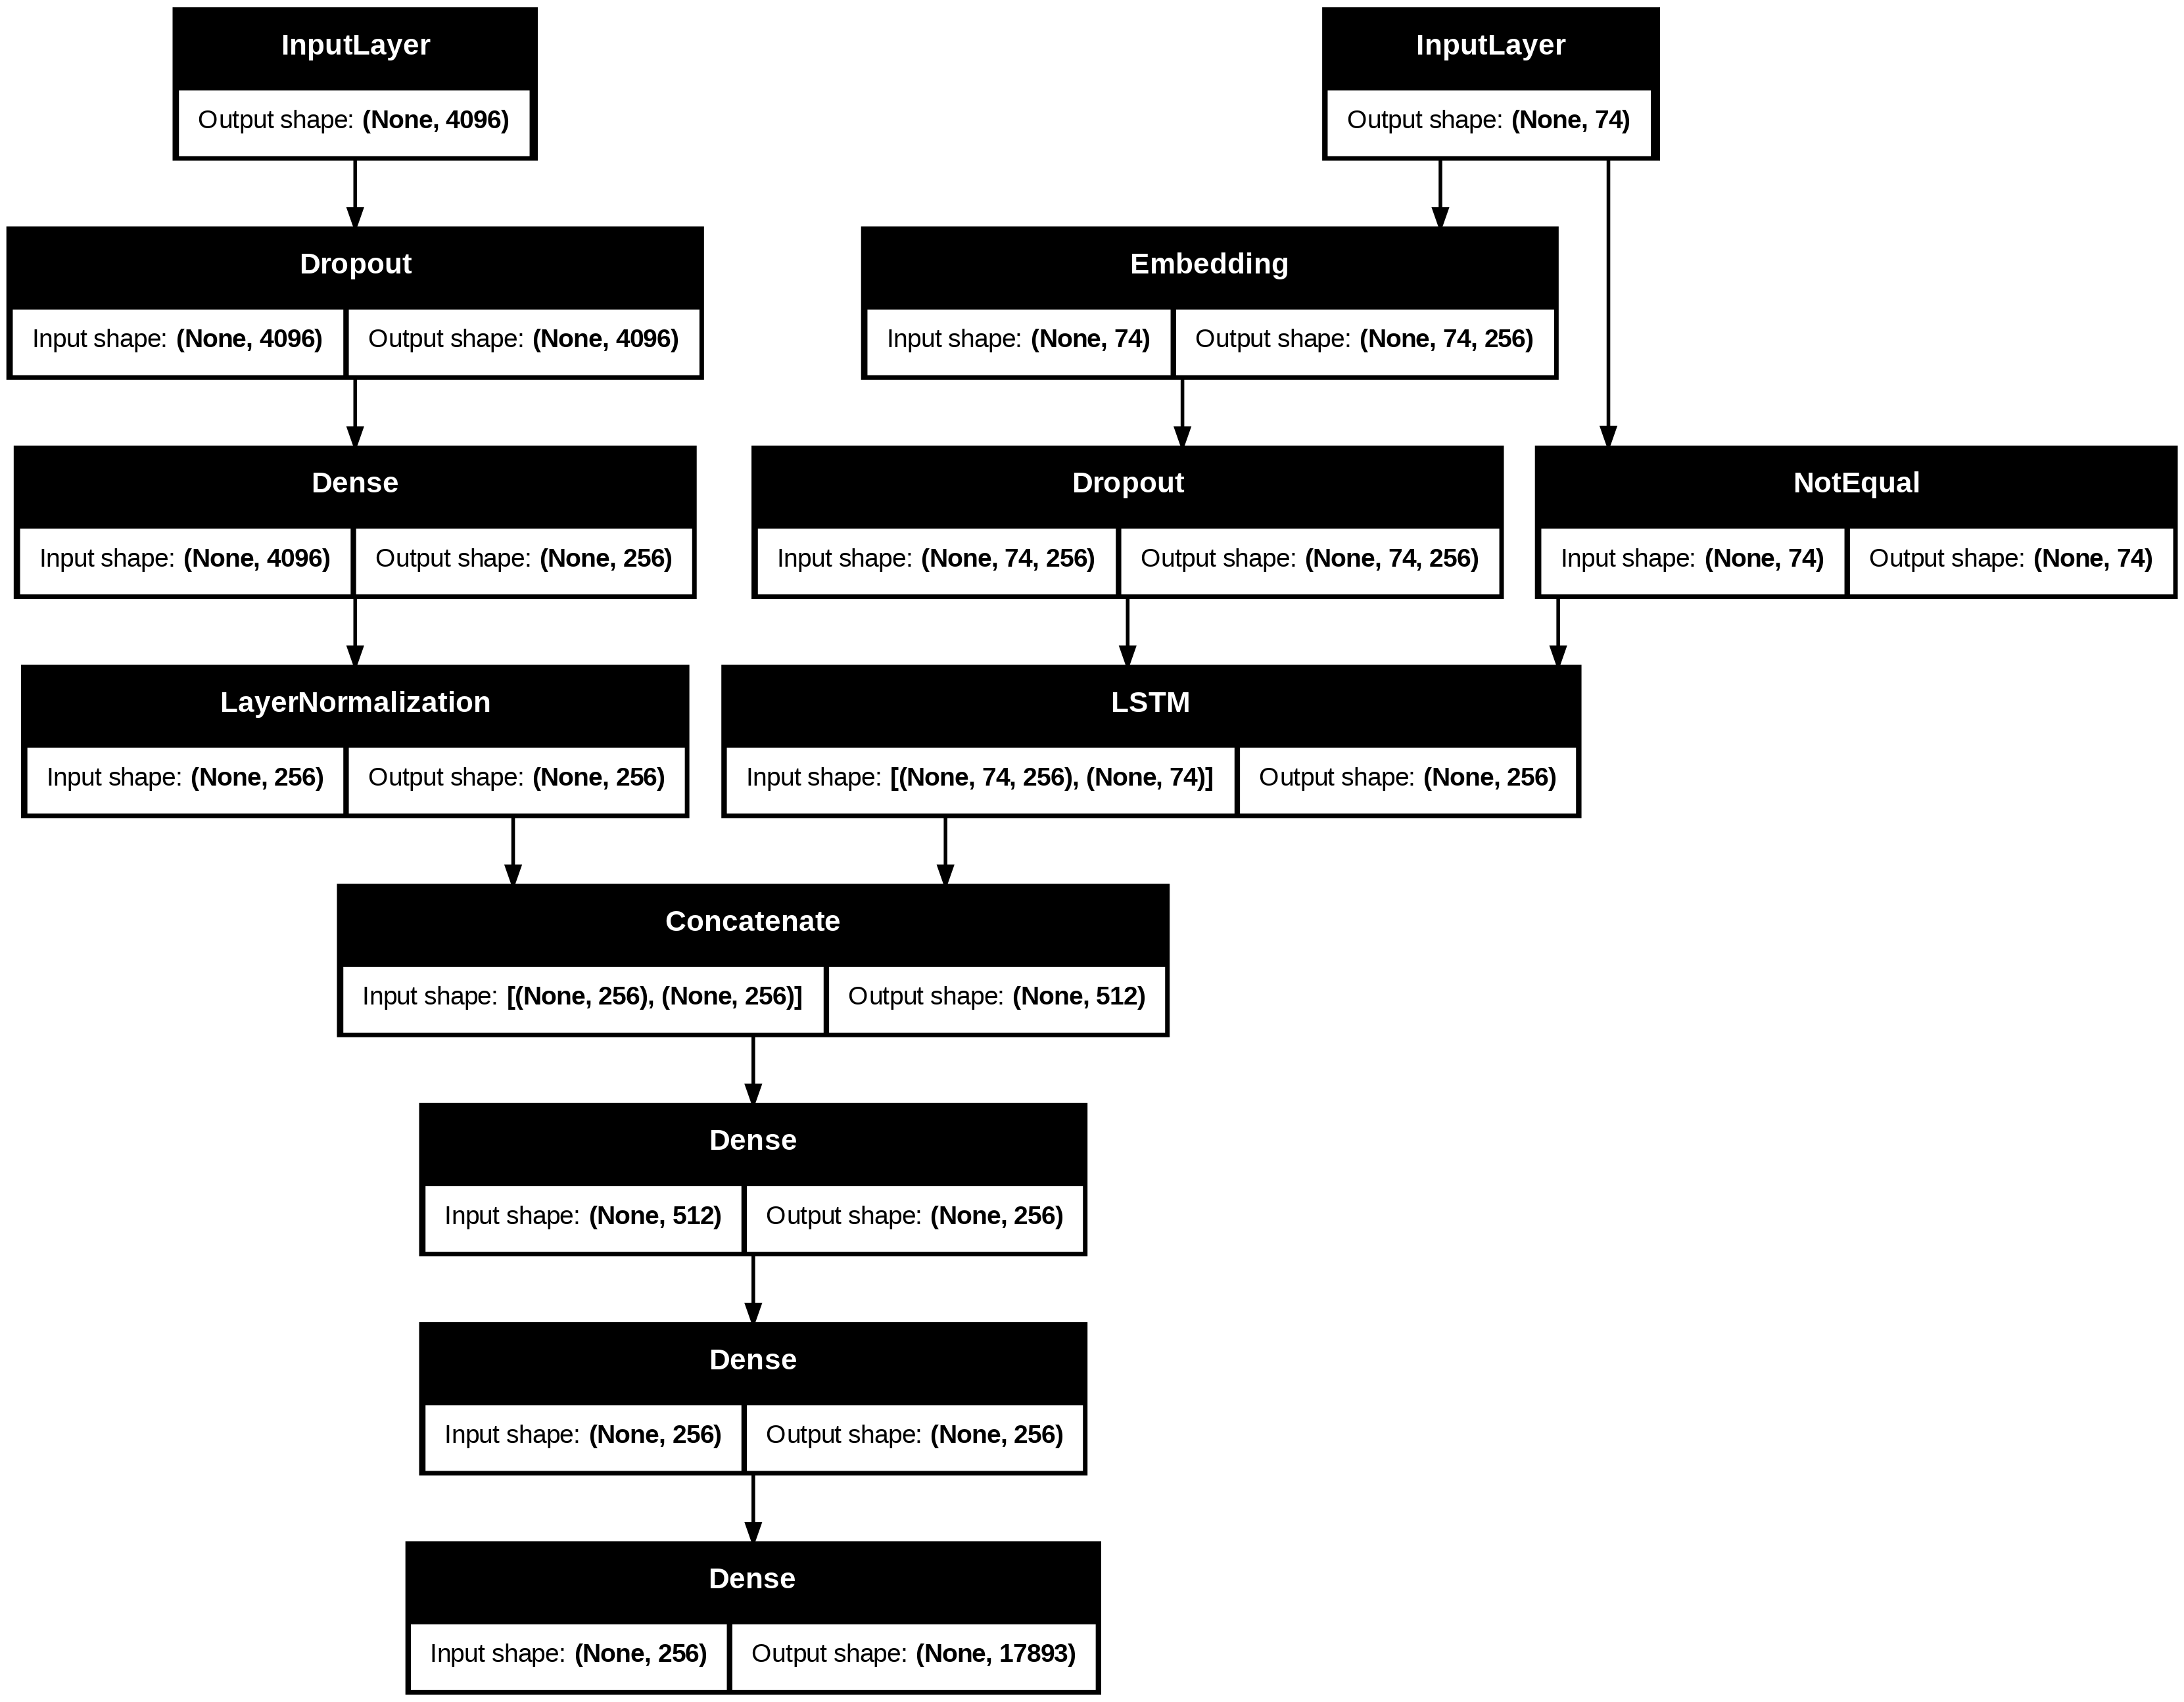

In [9]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

# Image Feature layers
inputs1 = Input(shape=(4096,), name='image_input')
Features1 = Dropout(0.0, name='image_dropout')(inputs1)
Features2 = Dense(256, activation='relu', name='image_dense')(Features1)
Features3 = LayerNormalization(name='image_norm')(Features2)

# Text Feature layers
inputs2 = Input(shape=(max_length_cap,), name='text_input')
seq1 = Embedding(vocab_size, 256, mask_zero=True, name='text_embedding')(inputs2)
seq2 = Dropout(0.0, name='text_dropout')(seq1)
seq3 = LSTM(256, name='text_lstm')(seq2)

# Fusion
fusion = concatenate([Features3, seq3], name='fusion_concat')
decoder1 = Dense(256, activation='relu', name='decoder_dense1')(fusion)
decoder2 = Dense(256, activation='relu', name='decoder_dense2')(decoder1)

# Output
outputs = Dense(vocab_size, activation='softmax', name='output_layer')(decoder2)

# Functional API
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(
    loss='sparse_categorical_crossentropy',  # for integer targets
    optimizer=Adam(learning_rate=0.0005),    # half the default learning rate leads to more stable convergence
    metrics=['accuracy']
)

# Plot the model
plot_model(model, show_shapes=True)

NotEqual is an internal layer created by mask_zero=True in the Embedding layer. It checks: `input != 0`

This mask is passed to the LSTM so it can ignore padding tokens during training.

In [10]:
# One quick dummy forward pass
import numpy as np

dummy_img = np.random.rand(1, 4096)
dummy_seq = np.random.randint(1, vocab_size, size=(1, max_length_cap))

# softmax score, 1D array of probabilities over the vocabulary (vocab_size = 17892)
# the model's confidence that a particular word is the next in the caption
model.predict([dummy_img, dummy_seq])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[5.7654859e-05, 5.2606927e-05, 5.1709321e-05, ..., 6.1411163e-05,
        5.8639584e-05, 4.6355610e-05]], dtype=float32)

In [11]:
image_id = train_id[0].split('.')[0]
print("Image vector mean/std:", np.mean(Img_features[image_id]), np.std(Img_features[image_id]))
print("Captions:", mapping[train_id[0]])


Image vector mean/std: 0.5856419 1.1218929
Captions: ['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq', 'startseq two young white males are outside near many bushes endseq', 'startseq two men in green shirts are standing in yard endseq', 'startseq man in blue shirt standing in garden endseq', 'startseq two friends enjoy time spent together endseq']


### Define data generator to prepare training data for a multi-input model
**(image features, partial caption) → next word**

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import random

def data_generator(data_keys, features, mapping, tokenizer, max_length, vocab_size, batch_size):
    """
    Generator that yields batches of training data for image captioning.
    Each sample consists of:
    - X1: image feature vector (from CNN)
    - X2: input sequence of word indices (padded)
    - y: target word index (integer, not one-hot)

    This version is optimized for use with sparse_categorical_crossentropy.
    """
    X1, X2, y = [], [], []
    n = 0

    while True:
        # Shuffle image keys to randomize batch order
        random.shuffle(data_keys)

        for key in data_keys:
            captions = mapping[key]

            # Process each caption associated with the current image
            for caption in captions:
                # Convert caption text to a sequence of token IDs
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Generate multiple input-output pairs from the sequence
                for i in range(1, len(seq)):
                    # Input sequence: all tokens before position i
                    in_seq = seq[:i]
                    # Output token: the token at position i
                    out_seq = seq[i]

                    # Skip if target word is padding (index 0)
                    if out_seq == 0:
                        continue

                    # Pad input sequence to fixed length
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

                    # Get image ID (strip file extension)
                    image_id = key.split('.')[0]

                    # Sanity checks
                    assert image_id in features, f"Missing image_id: {image_id}"
                    assert features[image_id].shape == (4096,), f"Bad shape: {features[image_id].shape}"

                    # Append sample to batch buffers
                    X1.append(features[image_id])  # image features
                    X2.append(in_seq)              # input sequence
                    y.append(out_seq)              # target word index (integer)

                    n += 1  # Count samples

                    # Yield batch when full
                    if n == batch_size:
                        yield (np.array(X1), np.array(X2)), np.array(y)
                        X1, X2, y = [], [], []
                        n = 0

In [13]:
# Create a generator instance
test_generator = data_generator(
    data_keys = train_id,           # or test_id if you want to inspect test samples
    features = Img_features,
    mapping = mapping,
    tokenizer = tokenizer,
    max_length = max_length_cap,
    vocab_size = vocab_size,
    batch_size = 64                # match your training batch size
)

# Fetch one batch from the generator
(X1_batch, X2_batch), y_batch = next(test_generator)

# Print shapes to verify structure
print("Image vector shape:  X1_batch", X1_batch.shape)       # Expected: (64, 4096)
print("Caption input shape: X2_batch", X2_batch.shape)        # Expected: (64, max_length)
print("Target shape:        y_batch ", y_batch.shape)          # Expected: (64, vocab_size)

# Fetch one batch from the generator
(X1_batch, X2_batch), y_batch = next(test_generator)

# Inspect one sample
print("\nSample image vector (mean/std):", np.mean(X1_batch[0]), np.std(X1_batch[0]))
print("Sample image vector [:20]\n", X1_batch[0][:20])
print("Sample input sequence:", X2_batch[0])
print("Sample target word:", np.argmax(y_batch[0]))


Image vector shape:  X1_batch  (64, 4096)
Caption input shape: X2_batch (64, 74)
Target shape:        y_batch (64,)

Sample image vector (mean/std): 0.4333765 0.9599941
Sample image vector [:20]
 [0.        0.8911375 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.8715304 1.0328498
 0.        0.        0.        0.        0.        0.       ]
Sample input sequence: [  1  56 243 613  10  72   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Sample target word: 0


In [14]:
for i in range(5):
    print(f"\nSample {i}")
    print("Input sequence:", X2_batch[i])
    print("Target word index:", np.argmax(y_batch[i]))



Sample 0
Input sequence: [  1  56 243 613  10  72   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Target word index: 0

Sample 1
Input sequence: [  1  56 243 613  10  72  50   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Target word index: 0

Sample 2
Input sequence: [  1  56 243 613  10  72  50 421   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 74)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dropout       │ (None, 4096)      │          0 │ image_input[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 74, 256)   │  4,580,608 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dense (Dense) │ (None, 256)       │  1,048,832 │ image_dropout[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_dropout        │ (None, 74, 256)   │          0 │ text_embedding[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 74)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_norm          │ (None, 256)       │        512 │ image_dense[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_lstm (LSTM)    │ (None, 256)       │    525,312 │ text_dropout[0][… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_concat       │ (None, 512)       │          0 │ image_norm[0][0], │
│ (Concatenate)       │                   │            │ text_lstm[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense1      │ (None, 256)       │    131,328 │ fusion_concat[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense2      │ (None, 256)       │     65,792 │ decoder_dense1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 17893)     │  4,598,501 │ decoder_dense2[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,950,885 (41.77 MB)

 Trainable params: 10,950,885 (41.77 MB)

 Non-trainable params: 0 (0.00 B)

### Feature Scale Inspection

In [16]:
from tensorflow.keras.models import Model
import numpy as np

# Create inspection model
inspect_model = Model(inputs=model.inputs, outputs=[
    model.get_layer('image_norm').output,   # Normalized image features
    model.get_layer('text_lstm').output     # Encoded text features
])


In [17]:
(X_img, X_seq), _ = next(test_generator)
img_features, text_features = inspect_model.predict([X_img, X_seq])

def describe(name, tensor):
    print(f"{name} — shape: {tensor.shape}")
    print(f"  Mean: {np.mean(tensor):.4f}")
    print(f"  Std:  {np.std(tensor):.4f}")
    print(f"  Min:  {np.min(tensor):.4f}")
    print(f"  Max:  {np.max(tensor):.4f}")
    print()

describe("Normalized Image Features", img_features)
describe("Encoded Text Features", text_features)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
Normalized Image Features — shape: (64, 256)
  Mean: -0.0000
  Std:  0.9995
  Min:  -0.7206
  Max:  4.3096

Encoded Text Features — shape: (64, 256)
  Mean: -0.0002
  Std:  0.0067
  Min:  -0.0263
  Max:  0.0267



### Train the multimodel

A batch is a group of training samples where each sample consists of:
- A 4096-d image feature vector (from VGG16 fc2)
- A partial caption sequence (padded to max_length_cap)
- A target word (one-hot encoded over vocab_size)

Batch_size = 64 means:

Every training step processes 64 samples, not 64 images.
These samples may come from multiple images and captions.

The generator yields batches of shape:

- X1: (64, 4096) → image features
- X2: (64, max_length_cap) → input sequences
- y: (64, vocab_size) → target words

In [18]:
epochs = 200
batch_size = 64
steps = (len(train_id)//batch_size)

history_all = {'loss': [], 'accuracy': []}

for i in tqdm(range(epochs)):
    print('  Epoch:', i)
    generator = data_generator(train_id, Img_features, mapping, tokenizer, max_length_cap, vocab_size, batch_size)

    history = model.fit(generator, epochs=1, steps_per_epoch=steps, shuffle=True, verbose=1)

    # Save loss and accuracy
    history_all['loss'].append(history.history['loss'][0])
    history_all['accuracy'].append(history.history['accuracy'][0])


  0%|          | 0/200 [00:00<?, ?it/s]

  Epoch: 0
446/446 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.0816 - loss: 6.9110


  0%|          | 1/200 [00:12<40:25, 12.19s/it]

  Epoch: 1
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1468 - loss: 5.6694


  1%|          | 2/200 [00:19<30:56,  9.38s/it]

  Epoch: 2
446/446 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.1716 - loss: 5.3160


  2%|▏         | 3/200 [00:28<30:06,  9.17s/it]

  Epoch: 3
446/446 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.1942 - loss: 5.1776


  2%|▏         | 4/200 [00:37<29:38,  9.07s/it]

  Epoch: 4
446/446 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.1916 - loss: 5.0351


  2%|▎         | 5/200 [00:46<29:03,  8.94s/it]

  Epoch: 5
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2134 - loss: 4.8182


  3%|▎         | 6/200 [00:56<30:22,  9.39s/it]

  Epoch: 6
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2121 - loss: 4.8206


  4%|▎         | 7/200 [01:04<28:45,  8.94s/it]

  Epoch: 7
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2222 - loss: 4.7853


  4%|▍         | 8/200 [01:11<26:58,  8.43s/it]

  Epoch: 8
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2238 - loss: 4.6830


  4%|▍         | 9/200 [01:19<26:21,  8.28s/it]

  Epoch: 9
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2322 - loss: 4.5772


  5%|▌         | 10/200 [01:27<25:20,  8.00s/it]

  Epoch: 10
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2332 - loss: 4.6143


  6%|▌         | 11/200 [01:34<25:06,  7.97s/it]

  Epoch: 11
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2370 - loss: 4.5297


  6%|▌         | 12/200 [01:42<24:47,  7.91s/it]

  Epoch: 12
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2483 - loss: 4.4882


  6%|▋         | 13/200 [01:50<24:23,  7.82s/it]

  Epoch: 13
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2507 - loss: 4.3819


  7%|▋         | 14/200 [01:58<24:20,  7.85s/it]

  Epoch: 14
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2439 - loss: 4.3982


  8%|▊         | 15/200 [02:05<23:42,  7.69s/it]

  Epoch: 15
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2425 - loss: 4.4713


  8%|▊         | 16/200 [02:13<23:48,  7.76s/it]

  Epoch: 16
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2450 - loss: 4.4344


  8%|▊         | 17/200 [02:21<24:03,  7.89s/it]

  Epoch: 17
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2517 - loss: 4.2870


  9%|▉         | 18/200 [02:29<23:44,  7.83s/it]

  Epoch: 18
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2482 - loss: 4.3407


 10%|▉         | 19/200 [02:37<23:47,  7.89s/it]

  Epoch: 19
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2552 - loss: 4.2742


 10%|█         | 20/200 [02:44<23:09,  7.72s/it]

  Epoch: 20
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2567 - loss: 4.3346


 10%|█         | 21/200 [02:52<23:14,  7.79s/it]

  Epoch: 21
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2625 - loss: 4.2080


 11%|█         | 22/200 [03:00<22:52,  7.71s/it]

  Epoch: 22
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2581 - loss: 4.2664


 12%|█▏        | 23/200 [03:10<25:02,  8.49s/it]

  Epoch: 23
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2649 - loss: 4.1856


 12%|█▏        | 24/200 [03:18<24:32,  8.37s/it]

  Epoch: 24
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2656 - loss: 4.0924


 12%|█▎        | 25/200 [03:26<23:40,  8.12s/it]

  Epoch: 25
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2718 - loss: 4.1257


 13%|█▎        | 26/200 [03:34<23:22,  8.06s/it]

  Epoch: 26
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2682 - loss: 4.1068


 14%|█▎        | 27/200 [03:42<23:09,  8.03s/it]

  Epoch: 27
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2738 - loss: 4.1495


 14%|█▍        | 28/200 [03:49<22:30,  7.85s/it]

  Epoch: 28
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2745 - loss: 4.0966


 14%|█▍        | 29/200 [03:57<22:27,  7.88s/it]

  Epoch: 29
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2586 - loss: 4.1919


 15%|█▌        | 30/200 [04:04<21:51,  7.72s/it]

  Epoch: 30
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2643 - loss: 4.1404


 16%|█▌        | 31/200 [04:15<23:53,  8.48s/it]

  Epoch: 31
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2723 - loss: 4.1127


 16%|█▌        | 32/200 [04:23<23:24,  8.36s/it]

  Epoch: 32
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2699 - loss: 4.1004


 16%|█▋        | 33/200 [04:30<22:27,  8.07s/it]

  Epoch: 33
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2690 - loss: 4.0849


 17%|█▋        | 34/200 [04:40<24:09,  8.73s/it]

  Epoch: 34
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2691 - loss: 4.1320


 18%|█▊        | 35/200 [04:51<25:17,  9.20s/it]

  Epoch: 35
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2847 - loss: 4.0324


 18%|█▊        | 36/200 [04:58<23:53,  8.74s/it]

  Epoch: 36
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2791 - loss: 4.0193


 18%|█▊        | 37/200 [05:06<22:53,  8.43s/it]

  Epoch: 37
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2780 - loss: 4.0254


 19%|█▉        | 38/200 [05:14<22:22,  8.29s/it]

  Epoch: 38
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2766 - loss: 4.0078


 20%|█▉        | 39/200 [05:21<21:27,  8.00s/it]

  Epoch: 39
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2844 - loss: 4.0572


 20%|██        | 40/200 [05:29<21:18,  7.99s/it]

  Epoch: 40
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2754 - loss: 4.0588


 20%|██        | 41/200 [05:39<22:59,  8.68s/it]

  Epoch: 41
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2849 - loss: 4.0163


 21%|██        | 42/200 [05:47<21:51,  8.30s/it]

  Epoch: 42
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2792 - loss: 4.0121


 22%|██▏       | 43/200 [05:55<21:31,  8.23s/it]

  Epoch: 43
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2823 - loss: 3.9701


 22%|██▏       | 44/200 [06:03<21:01,  8.09s/it]

  Epoch: 44
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2817 - loss: 4.0132


 22%|██▎       | 45/200 [06:11<20:47,  8.05s/it]

  Epoch: 45
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2817 - loss: 3.9652


 23%|██▎       | 46/200 [06:19<20:48,  8.11s/it]

  Epoch: 46
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2768 - loss: 4.0069


 24%|██▎       | 47/200 [06:26<20:14,  7.94s/it]

  Epoch: 47
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2816 - loss: 3.9623


 24%|██▍       | 48/200 [06:35<20:13,  7.98s/it]

  Epoch: 48
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2883 - loss: 3.9176


 24%|██▍       | 49/200 [06:45<21:49,  8.67s/it]

  Epoch: 49
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2820 - loss: 3.9700


 25%|██▌       | 50/200 [06:52<20:54,  8.36s/it]

  Epoch: 50
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2839 - loss: 3.9402


 26%|██▌       | 51/200 [07:01<20:34,  8.29s/it]

  Epoch: 51
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2940 - loss: 3.8371


 26%|██▌       | 52/200 [07:08<20:06,  8.15s/it]

  Epoch: 52
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2946 - loss: 3.9015


 26%|██▋       | 53/200 [07:16<19:42,  8.04s/it]

  Epoch: 53
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2906 - loss: 3.8867


 27%|██▋       | 54/200 [07:24<19:41,  8.09s/it]

  Epoch: 54
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2881 - loss: 3.9216


 28%|██▊       | 55/200 [07:32<19:06,  7.91s/it]

  Epoch: 55
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2841 - loss: 3.9039


 28%|██▊       | 56/200 [07:40<19:05,  7.96s/it]

  Epoch: 56
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2898 - loss: 3.8669


 28%|██▊       | 57/200 [07:48<18:47,  7.89s/it]

  Epoch: 57
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2936 - loss: 3.8631


 29%|██▉       | 58/200 [07:55<18:35,  7.86s/it]

  Epoch: 58
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2896 - loss: 3.8634


 30%|██▉       | 59/200 [08:04<18:38,  7.93s/it]

  Epoch: 59
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2922 - loss: 3.9156


 30%|███       | 60/200 [08:11<18:10,  7.79s/it]

  Epoch: 60
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2915 - loss: 3.7969


 30%|███       | 61/200 [08:19<18:15,  7.88s/it]

  Epoch: 61
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2885 - loss: 3.8629


 31%|███       | 62/200 [08:29<19:46,  8.60s/it]

  Epoch: 62
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2927 - loss: 3.8528


 32%|███▏      | 63/200 [08:37<18:56,  8.30s/it]

  Epoch: 63
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2956 - loss: 3.7815


 32%|███▏      | 64/200 [08:45<18:36,  8.21s/it]

  Epoch: 64
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2874 - loss: 3.8283


 32%|███▎      | 65/200 [08:53<18:11,  8.09s/it]

  Epoch: 65
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2920 - loss: 3.8177


 33%|███▎      | 66/200 [09:01<17:47,  7.97s/it]

  Epoch: 66
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2953 - loss: 3.8101


 34%|███▎      | 67/200 [09:09<17:42,  7.99s/it]

  Epoch: 67
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2926 - loss: 3.8326


 34%|███▍      | 68/200 [09:19<19:04,  8.67s/it]

  Epoch: 68
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2970 - loss: 3.8361


 34%|███▍      | 69/200 [09:26<18:16,  8.37s/it]

  Epoch: 69
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3043 - loss: 3.7597


 35%|███▌      | 70/200 [09:34<17:51,  8.24s/it]

  Epoch: 70
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2947 - loss: 3.8087


 36%|███▌      | 71/200 [09:42<17:12,  8.00s/it]

  Epoch: 71
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3033 - loss: 3.7747


 36%|███▌      | 72/200 [09:50<17:08,  8.03s/it]

  Epoch: 72
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2989 - loss: 3.8559


 36%|███▋      | 73/200 [09:58<16:50,  7.95s/it]

  Epoch: 73
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3016 - loss: 3.7211


 37%|███▋      | 74/200 [10:08<18:10,  8.66s/it]

  Epoch: 74
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3095 - loss: 3.6611


 38%|███▊      | 75/200 [10:16<17:38,  8.47s/it]

  Epoch: 75
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2997 - loss: 3.6988


 38%|███▊      | 76/200 [10:24<17:00,  8.23s/it]

  Epoch: 76
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2921 - loss: 3.7992


 38%|███▊      | 77/200 [10:31<16:32,  8.07s/it]

  Epoch: 77
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3116 - loss: 3.7026


 39%|███▉      | 78/200 [10:42<17:45,  8.73s/it]

  Epoch: 78
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3022 - loss: 3.7067


 40%|███▉      | 79/200 [10:49<16:57,  8.41s/it]

  Epoch: 79
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3048 - loss: 3.7888


 40%|████      | 80/200 [10:57<16:26,  8.22s/it]

  Epoch: 80
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3112 - loss: 3.7406


 40%|████      | 81/200 [11:05<16:09,  8.15s/it]

  Epoch: 81
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2926 - loss: 3.7516


 41%|████      | 82/200 [11:13<15:36,  7.93s/it]

  Epoch: 82
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2892 - loss: 3.8511


 42%|████▏     | 83/200 [11:21<15:31,  7.96s/it]

  Epoch: 83
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2977 - loss: 3.7665


 42%|████▏     | 84/200 [11:28<15:06,  7.82s/it]

  Epoch: 84
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3015 - loss: 3.6909


 42%|████▎     | 85/200 [11:36<15:02,  7.85s/it]

  Epoch: 85
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3066 - loss: 3.6950


 43%|████▎     | 86/200 [11:44<15:00,  7.90s/it]

  Epoch: 86
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3021 - loss: 3.7828


 44%|████▎     | 87/200 [11:51<14:35,  7.75s/it]

  Epoch: 87
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2968 - loss: 3.7655


 44%|████▍     | 88/200 [12:02<15:52,  8.51s/it]

  Epoch: 88
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3019 - loss: 3.7294


 44%|████▍     | 89/200 [12:10<15:25,  8.33s/it]

  Epoch: 89
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3045 - loss: 3.7191


 45%|████▌     | 90/200 [12:17<14:49,  8.08s/it]

  Epoch: 90
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3071 - loss: 3.6928


 46%|████▌     | 91/200 [12:25<14:38,  8.06s/it]

  Epoch: 91
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3082 - loss: 3.5757


 46%|████▌     | 92/200 [12:35<15:42,  8.73s/it]

  Epoch: 92
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3072 - loss: 3.7000


 46%|████▋     | 93/200 [12:43<14:54,  8.36s/it]

  Epoch: 93
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2958 - loss: 3.7894


 47%|████▋     | 94/200 [12:51<14:36,  8.27s/it]

  Epoch: 94
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3128 - loss: 3.6415


 48%|████▊     | 95/200 [12:58<14:03,  8.03s/it]

  Epoch: 95
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3013 - loss: 3.7463


 48%|████▊     | 96/200 [13:06<13:53,  8.02s/it]

  Epoch: 96
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3046 - loss: 3.7125


 48%|████▊     | 97/200 [13:14<13:43,  8.00s/it]

  Epoch: 97
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3127 - loss: 3.6047


 49%|████▉     | 98/200 [13:22<13:17,  7.82s/it]

  Epoch: 98
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3084 - loss: 3.7306


 50%|████▉     | 99/200 [13:30<13:14,  7.87s/it]

  Epoch: 99
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3052 - loss: 3.6622


 50%|█████     | 100/200 [13:37<12:53,  7.73s/it]

  Epoch: 100
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3117 - loss: 3.6561


 50%|█████     | 101/200 [13:45<12:56,  7.84s/it]

  Epoch: 101
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3031 - loss: 3.7071


 51%|█████     | 102/200 [13:56<14:00,  8.58s/it]

  Epoch: 102
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3021 - loss: 3.6862


 52%|█████▏    | 103/200 [14:03<13:21,  8.26s/it]

  Epoch: 103
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3086 - loss: 3.6178


 52%|█████▏    | 104/200 [14:11<13:05,  8.19s/it]

  Epoch: 104
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3104 - loss: 3.7240


 52%|█████▎    | 105/200 [14:19<12:48,  8.09s/it]

  Epoch: 105
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3138 - loss: 3.6451


 53%|█████▎    | 106/200 [14:27<12:28,  7.97s/it]

  Epoch: 106
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3100 - loss: 3.6539


 54%|█████▎    | 107/200 [14:35<12:25,  8.02s/it]

  Epoch: 107
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3205 - loss: 3.6597


 54%|█████▍    | 108/200 [14:42<12:01,  7.84s/it]

  Epoch: 108
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3098 - loss: 3.6008


 55%|█████▍    | 109/200 [14:50<11:59,  7.91s/it]

  Epoch: 109
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3154 - loss: 3.5929


 55%|█████▌    | 110/200 [14:58<11:47,  7.86s/it]

  Epoch: 110
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3059 - loss: 3.7461


 56%|█████▌    | 111/200 [15:06<11:36,  7.82s/it]

  Epoch: 111
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3090 - loss: 3.6552


 56%|█████▌    | 112/200 [15:14<11:34,  7.89s/it]

  Epoch: 112
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3149 - loss: 3.6006


 56%|█████▋    | 113/200 [15:21<11:14,  7.76s/it]

  Epoch: 113
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3214 - loss: 3.5802


 57%|█████▋    | 114/200 [15:29<11:13,  7.83s/it]

  Epoch: 114
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3084 - loss: 3.6993


 57%|█████▊    | 115/200 [15:37<11:01,  7.78s/it]

  Epoch: 115
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3113 - loss: 3.6154


 58%|█████▊    | 116/200 [15:45<10:52,  7.77s/it]

  Epoch: 116
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3057 - loss: 3.6609


 58%|█████▊    | 117/200 [15:53<10:52,  7.87s/it]

  Epoch: 117
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3108 - loss: 3.6424


 59%|█████▉    | 118/200 [16:00<10:35,  7.75s/it]

  Epoch: 118
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3056 - loss: 3.6700


 60%|█████▉    | 119/200 [16:08<10:35,  7.84s/it]

  Epoch: 119
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3182 - loss: 3.6055


 60%|██████    | 120/200 [16:16<10:21,  7.77s/it]

  Epoch: 120
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3089 - loss: 3.6199


 60%|██████    | 121/200 [16:24<10:16,  7.80s/it]

  Epoch: 121
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3198 - loss: 3.6011


 61%|██████    | 122/200 [16:32<10:14,  7.88s/it]

  Epoch: 122
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3131 - loss: 3.5843


 62%|██████▏   | 123/200 [16:39<09:56,  7.74s/it]

  Epoch: 123
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3081 - loss: 3.7184


 62%|██████▏   | 124/200 [16:47<09:55,  7.84s/it]

  Epoch: 124
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3132 - loss: 3.6127


 62%|██████▎   | 125/200 [16:55<09:41,  7.75s/it]

  Epoch: 125
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3138 - loss: 3.6517


 63%|██████▎   | 126/200 [17:03<09:39,  7.83s/it]

  Epoch: 126
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3100 - loss: 3.6761


 64%|██████▎   | 127/200 [17:11<09:37,  7.91s/it]

  Epoch: 127
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3123 - loss: 3.6522


 64%|██████▍   | 128/200 [17:18<09:20,  7.78s/it]

  Epoch: 128
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3085 - loss: 3.6334


 64%|██████▍   | 129/200 [17:27<09:20,  7.89s/it]

  Epoch: 129
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3108 - loss: 3.6721


 65%|██████▌   | 130/200 [17:34<09:03,  7.76s/it]

  Epoch: 130
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3121 - loss: 3.5897


 66%|██████▌   | 131/200 [17:42<08:59,  7.82s/it]

  Epoch: 131
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3171 - loss: 3.5753


 66%|██████▌   | 132/200 [17:50<08:57,  7.91s/it]

  Epoch: 132
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3162 - loss: 3.6224


 66%|██████▋   | 133/200 [17:58<08:41,  7.78s/it]

  Epoch: 133
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3061 - loss: 3.6819


 67%|██████▋   | 134/200 [18:06<08:38,  7.85s/it]

  Epoch: 134
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3148 - loss: 3.6392


 68%|██████▊   | 135/200 [18:13<08:23,  7.74s/it]

  Epoch: 135
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3050 - loss: 3.6308


 68%|██████▊   | 136/200 [18:21<08:22,  7.85s/it]

  Epoch: 136
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3119 - loss: 3.6637


 68%|██████▊   | 137/200 [18:29<08:18,  7.91s/it]

  Epoch: 137
446/446 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.3167 - loss: 3.6313


 69%|██████▉   | 138/200 [18:38<08:25,  8.15s/it]

  Epoch: 138
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3220 - loss: 3.5786


 70%|██████▉   | 139/200 [18:46<08:18,  8.17s/it]

  Epoch: 139
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3147 - loss: 3.5845


 70%|███████   | 140/200 [18:54<08:03,  8.06s/it]

  Epoch: 140
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3134 - loss: 3.5902


 70%|███████   | 141/200 [19:02<07:52,  8.01s/it]

  Epoch: 141
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3208 - loss: 3.5941


 71%|███████   | 142/200 [19:10<07:45,  8.02s/it]

  Epoch: 142
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3226 - loss: 3.5785


 72%|███████▏  | 143/200 [19:17<07:27,  7.85s/it]

  Epoch: 143
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3198 - loss: 3.5379


 72%|███████▏  | 144/200 [19:25<07:23,  7.92s/it]

  Epoch: 144
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3092 - loss: 3.6153


 72%|███████▎  | 145/200 [19:33<07:11,  7.85s/it]

  Epoch: 145
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3126 - loss: 3.6219


 73%|███████▎  | 146/200 [19:41<07:04,  7.87s/it]

  Epoch: 146
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3149 - loss: 3.6242


 74%|███████▎  | 147/200 [19:51<07:35,  8.59s/it]

  Epoch: 147
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3209 - loss: 3.5970


 74%|███████▍  | 148/200 [19:59<07:12,  8.32s/it]

  Epoch: 148
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3182 - loss: 3.6067


 74%|███████▍  | 149/200 [20:07<07:02,  8.29s/it]

  Epoch: 149
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3207 - loss: 3.6027


 75%|███████▌  | 150/200 [20:18<07:25,  8.90s/it]

  Epoch: 150
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3251 - loss: 3.5087


 76%|███████▌  | 151/200 [20:26<07:11,  8.80s/it]

  Epoch: 151
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3283 - loss: 3.4541


 76%|███████▌  | 152/200 [20:34<06:49,  8.52s/it]

  Epoch: 152
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3091 - loss: 3.6693


 76%|███████▋  | 153/200 [20:42<06:35,  8.42s/it]

  Epoch: 153
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3199 - loss: 3.6040


 77%|███████▋  | 154/200 [20:50<06:19,  8.26s/it]

  Epoch: 154
446/446 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3185 - loss: 3.5972


 78%|███████▊  | 155/200 [20:59<06:23,  8.51s/it]

  Epoch: 155
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3174 - loss: 3.5699


 78%|███████▊  | 156/200 [21:07<06:08,  8.38s/it]

  Epoch: 156
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3227 - loss: 3.5096


 78%|███████▊  | 157/200 [21:15<05:52,  8.20s/it]

  Epoch: 157
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3252 - loss: 3.5245


 79%|███████▉  | 158/200 [21:23<05:44,  8.19s/it]

  Epoch: 158
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3236 - loss: 3.4823


 80%|███████▉  | 159/200 [21:31<05:30,  8.05s/it]

  Epoch: 159
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3275 - loss: 3.5297


 80%|████████  | 160/200 [21:39<05:24,  8.12s/it]

  Epoch: 160
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3138 - loss: 3.6364


 80%|████████  | 161/200 [21:47<05:17,  8.13s/it]

  Epoch: 161
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3173 - loss: 3.5218


 81%|████████  | 162/200 [21:55<05:03,  7.99s/it]

  Epoch: 162
446/446 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.3207 - loss: 3.5366


 82%|████████▏ | 163/200 [22:04<05:02,  8.18s/it]

  Epoch: 163
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3221 - loss: 3.5504


 82%|████████▏ | 164/200 [22:11<04:46,  7.97s/it]

  Epoch: 164
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3250 - loss: 3.5148


 82%|████████▎ | 165/200 [22:19<04:40,  8.00s/it]

  Epoch: 165
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3314 - loss: 3.5098


 83%|████████▎ | 166/200 [22:27<04:33,  8.04s/it]

  Epoch: 166
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3187 - loss: 3.5192


 84%|████████▎ | 167/200 [22:35<04:20,  7.89s/it]

  Epoch: 167
446/446 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.3224 - loss: 3.5847


 84%|████████▍ | 168/200 [22:45<04:36,  8.66s/it]

  Epoch: 168
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3260 - loss: 3.5618


 84%|████████▍ | 169/200 [22:53<04:22,  8.46s/it]

  Epoch: 169
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3177 - loss: 3.5640


 85%|████████▌ | 170/200 [23:01<04:07,  8.24s/it]

  Epoch: 170
446/446 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.3236 - loss: 3.4727


 86%|████████▌ | 171/200 [23:10<04:02,  8.35s/it]

  Epoch: 171
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3294 - loss: 3.4610


 86%|████████▌ | 172/200 [23:18<03:52,  8.29s/it]

  Epoch: 172
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3198 - loss: 3.5848


 86%|████████▋ | 173/200 [23:26<03:42,  8.23s/it]

  Epoch: 173
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3209 - loss: 3.5596


 87%|████████▋ | 174/200 [23:34<03:33,  8.22s/it]

  Epoch: 174
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3167 - loss: 3.5777


 88%|████████▊ | 175/200 [23:42<03:20,  8.00s/it]

  Epoch: 175
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3249 - loss: 3.5057


 88%|████████▊ | 176/200 [23:50<03:13,  8.05s/it]

  Epoch: 176
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3223 - loss: 3.4622


 88%|████████▊ | 177/200 [23:57<03:01,  7.90s/it]

  Epoch: 177
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.3284 - loss: 3.4989


 89%|████████▉ | 178/200 [24:08<03:09,  8.63s/it]

  Epoch: 178
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3275 - loss: 3.4615


 90%|████████▉ | 179/200 [24:16<02:58,  8.50s/it]

  Epoch: 179
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3214 - loss: 3.5070


 90%|█████████ | 180/200 [24:23<02:44,  8.22s/it]

  Epoch: 180
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3246 - loss: 3.5123


 90%|█████████ | 181/200 [24:31<02:35,  8.19s/it]

  Epoch: 181
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3175 - loss: 3.5136


 91%|█████████ | 182/200 [24:40<02:27,  8.20s/it]

  Epoch: 182
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3313 - loss: 3.4468


 92%|█████████▏| 183/200 [24:47<02:16,  8.02s/it]

  Epoch: 183
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3251 - loss: 3.5204


 92%|█████████▏| 184/200 [24:55<02:08,  8.04s/it]

  Epoch: 184
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3348 - loss: 3.4170


 92%|█████████▎| 185/200 [25:03<01:58,  7.89s/it]

  Epoch: 185
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3325 - loss: 3.4288


 93%|█████████▎| 186/200 [25:11<01:51,  7.96s/it]

  Epoch: 186
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3179 - loss: 3.5084


 94%|█████████▎| 187/200 [25:19<01:43,  7.99s/it]

  Epoch: 187
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3310 - loss: 3.5323


 94%|█████████▍| 188/200 [25:27<01:34,  7.88s/it]

  Epoch: 188
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3310 - loss: 3.4612


 94%|█████████▍| 189/200 [25:35<01:27,  7.97s/it]

  Epoch: 189
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3232 - loss: 3.5128


 95%|█████████▌| 190/200 [25:42<01:18,  7.84s/it]

  Epoch: 190
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3306 - loss: 3.5019


 96%|█████████▌| 191/200 [25:51<01:11,  7.94s/it]

  Epoch: 191
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3257 - loss: 3.4635


 96%|█████████▌| 192/200 [25:59<01:03,  7.96s/it]

  Epoch: 192
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3311 - loss: 3.4837


 96%|█████████▋| 193/200 [26:06<00:55,  7.86s/it]

  Epoch: 193
446/446 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.3338 - loss: 3.4557


 97%|█████████▋| 194/200 [26:17<00:52,  8.70s/it]

  Epoch: 194
446/446 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.3299 - loss: 3.4089


 98%|█████████▊| 195/200 [26:27<00:45,  9.17s/it]

  Epoch: 195
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3158 - loss: 3.5875


 98%|█████████▊| 196/200 [26:35<00:35,  8.76s/it]

  Epoch: 196
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3288 - loss: 3.4930


 98%|█████████▊| 197/200 [26:43<00:25,  8.57s/it]

  Epoch: 197
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3295 - loss: 3.4018


 99%|█████████▉| 198/200 [26:53<00:18,  9.09s/it]

  Epoch: 198
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3283 - loss: 3.4762


100%|█████████▉| 199/200 [27:04<00:09,  9.44s/it]

  Epoch: 199
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3306 - loss: 3.5131


100%|██████████| 200/200 [27:11<00:00,  8.16s/it]


### Save the fitted model

In [19]:
model.save('/content/drive/MyDrive/flickr30k_images/Img_Model_One.keras')

🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻🔻

### Load model after reconnection
... import and mount ...

In [20]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/flickr30k_images/Img_Model_One.keras')

### Plot the learning curve

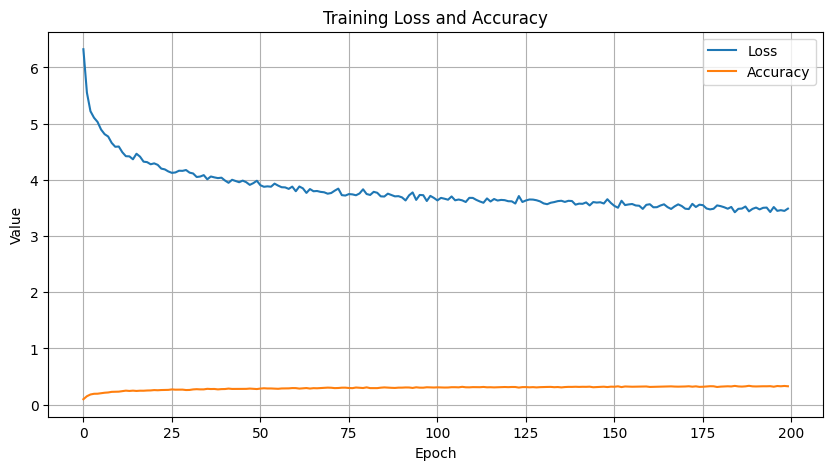

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_all['loss'], label='Loss')
plt.plot(history_all['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Generate captions for images



In [22]:
# Index to word: Use the built-in reverse mapping
def idx_to_word(integer, tokenizer):
    return tokenizer.index_word.get(integer)

In [23]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'  # Match preprocessing exactly
    for _ in range(max_length):
        # Encode and pad input sequence
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')

        # Predict the next word
        yhat = model.predict([image, seq], verbose=0)
        next_index = np.argmax(yhat)
        next_word = idx_to_word(next_index, tokenizer)

        # Stop if word is unknown or end token
        if next_word is None or next_word == 'endseq':
            break

        # Append word to input sequence
        in_text += ' ' + next_word

    return in_text.replace('startseq', '').strip()

In [24]:
import matplotlib.pyplot as plt
from PIL import Image
import os

BASE_DIR = '/content/drive/MyDrive/flickr30k_images/flickr30k_images/'

def visualize_prediction(image_name):
    image_id = image_name.split('.')[0]
    image_path = os.path.join(BASE_DIR, image_name)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print('_______________________Actual_________________')
    for caption in mapping[image_id + '.jpg']:
        print(caption.replace('startseq', '').replace('endseq', '').strip())

    y_pred = predict_caption(model, Img_features[image_id].reshape(1, 4096), tokenizer, max_length_cap)
    print('_____________________Predicted________________')
    print(y_pred)

### Test captioning for a random image

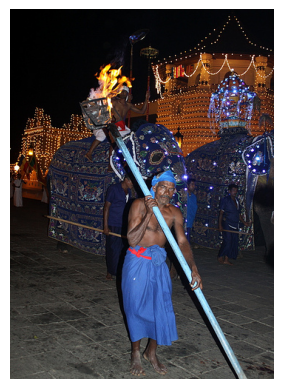

_______________________Actual_________________
native man in blue garb holds flaming torch on long pole in advance of pair of decorated marching elephants
man with long pole that has basket of fire on the tip outside in front of two elephants
black man with no shirt is carrying torch in front of bedazzled elephants
shirtless man in blue holding up large blue rod and looking at the camera
barefoot man holding long torch at festival
_____________________Predicted________________
man in black shirt and jeans is playing the guitar


In [25]:
import random

# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

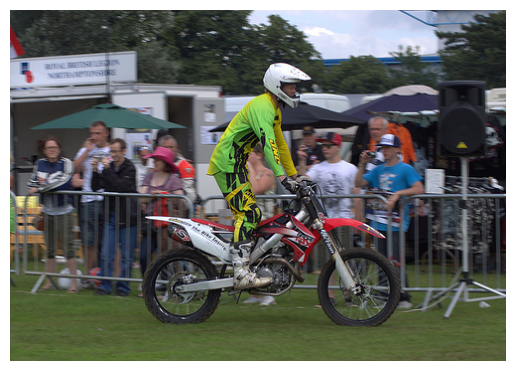

_______________________Actual_________________
man trying to stand in his motorcycle as he attempts for an incredible trick
man in green outfit shows off his red motorcycle for crowd
dirt bike rider in neon green outfit entertains the crowd
man is standing upright on motorcycle
today is the day of motorcycle racing
_____________________Predicted________________
man in blue shirt is riding bike


In [27]:
# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

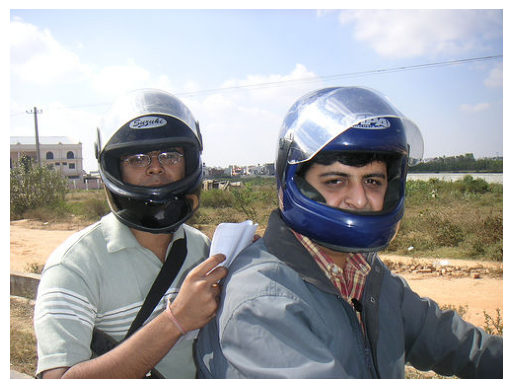

_______________________Actual_________________
two men wearing motorcycle helmets one carrying piece of paper
two men with helmets on motorized vehicle in the desert
two men are wearing helmet on their head
two men wearing helmets on motorcycle
two men wearing helmets are riding
_____________________Predicted________________
two men in red shirts and black pants are sitting on the ground


In [29]:
# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

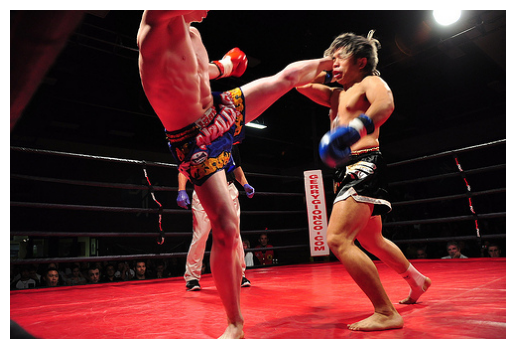

_______________________Actual_________________
the boxer kicked his opponent on the side of the face knocking his mouth guard out during the fight
man is kicking another man in the head inside of red ring while another man watches
one man round kicking another man in ring
one guy kicking another guy in the head
two kickboxers are fighting
_____________________Predicted________________
two men in white shorts and white shirt are playing basketball


In [30]:
# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

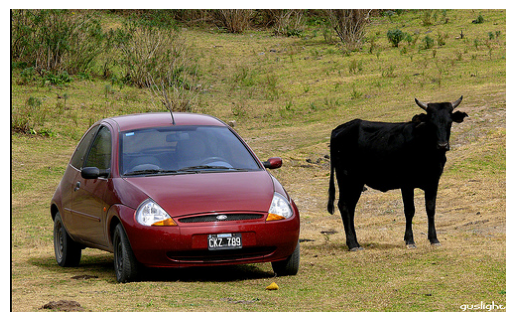

_______________________Actual_________________
there is small red car with black bull standing beside it in the middle of field
red car is parked next to black bull in grassy field
large black animal is as large as small red car
bull stands in field next to red car
red car parked next to cow in field
_____________________Predicted________________
man in black shirt and black pants is riding horse


In [31]:
# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜

### **CONCLUSION**:
### The main issue portrayed in this project is that the model does not truly "**pay attention**" to the images. That’s exactly where **modern deep learning** enters the realm of **attention mechanisms** and **transformers**. I believe the whole point of this project is to show why we need those; because with the current setup, even the best achievable accuracy hits a ceiling around 33%. No matter how much we tweak, without attention, the model simply doesn’t have the capability to see the image the way it should.
🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜
### With this final note, which indicates the need for **further study** and **continuous learning**, I end my internship. Thanks to everyone at CS_Internship whose **generosity** and **integrity** provided me with this great opportunity. Thank you! ❤️
